# Delhi Climate Prediction using LSTM Architecture
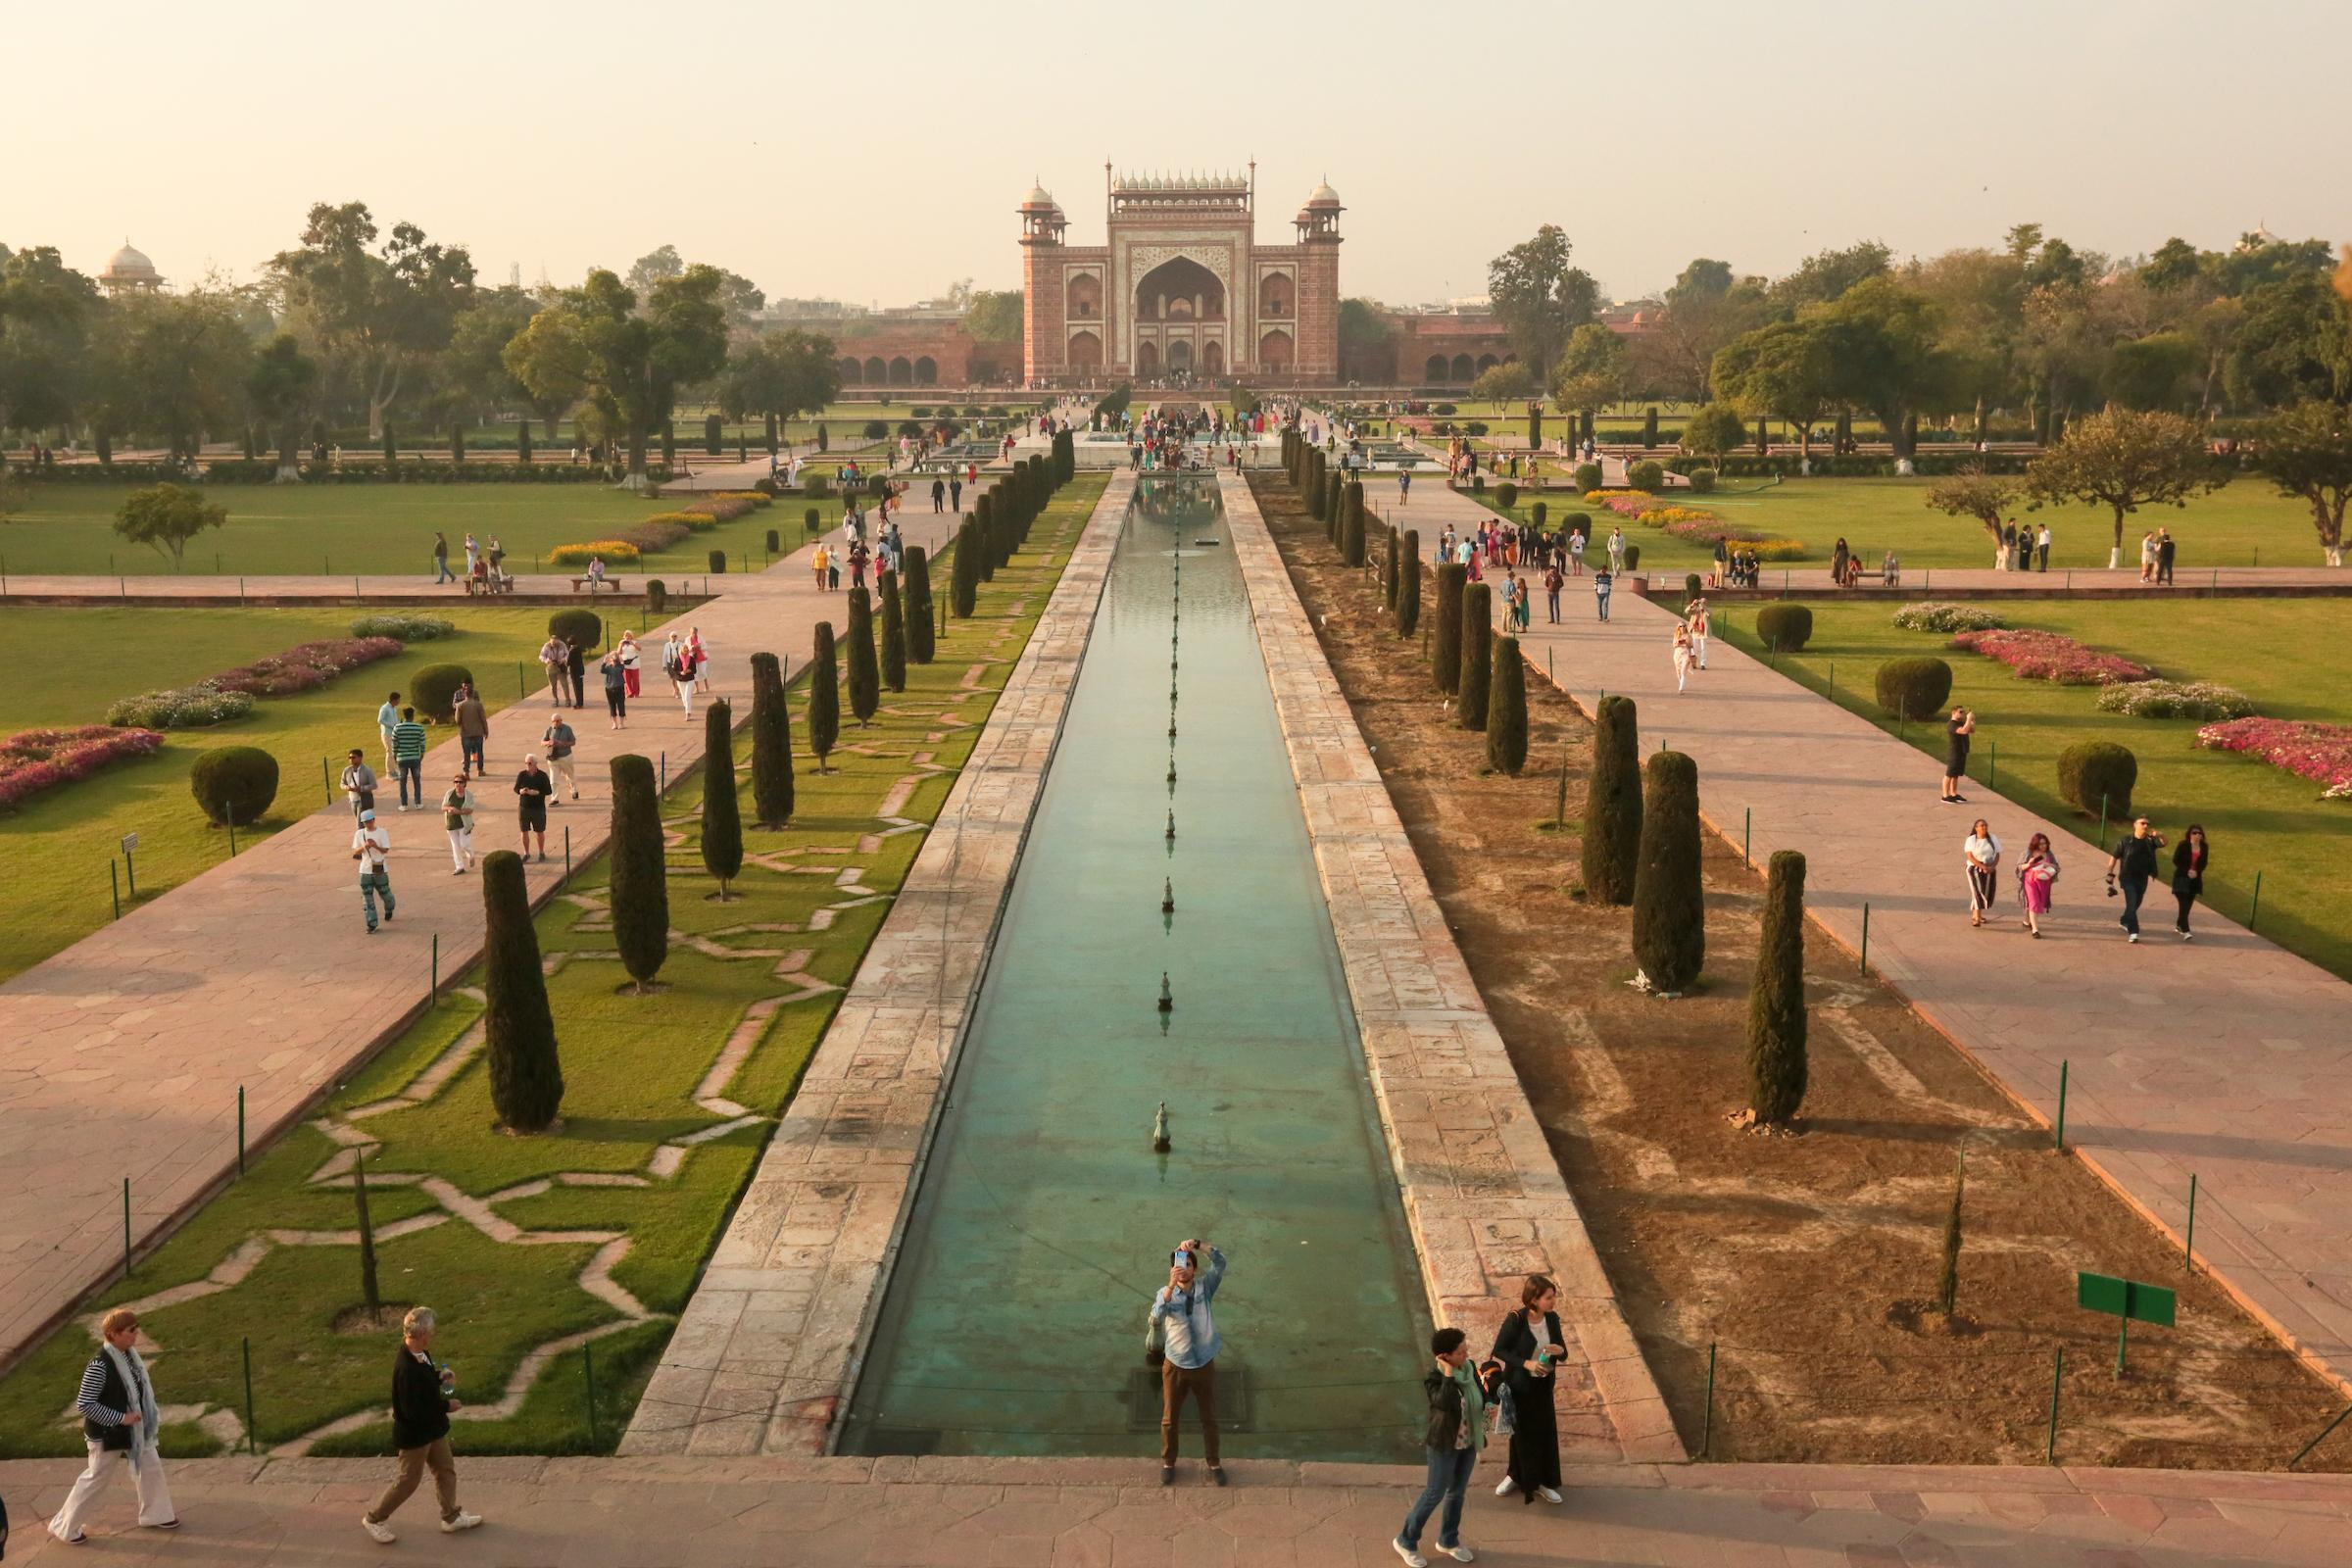

In [1]:

import numpy as np 
import pandas as pd 
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
import seaborn as sns


import os


# Reading the Dataset

In [2]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
test = pd.read_csv('DailyDelhiClimateTest.csv')
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


# Data Cleaning 

<AxesSubplot:>

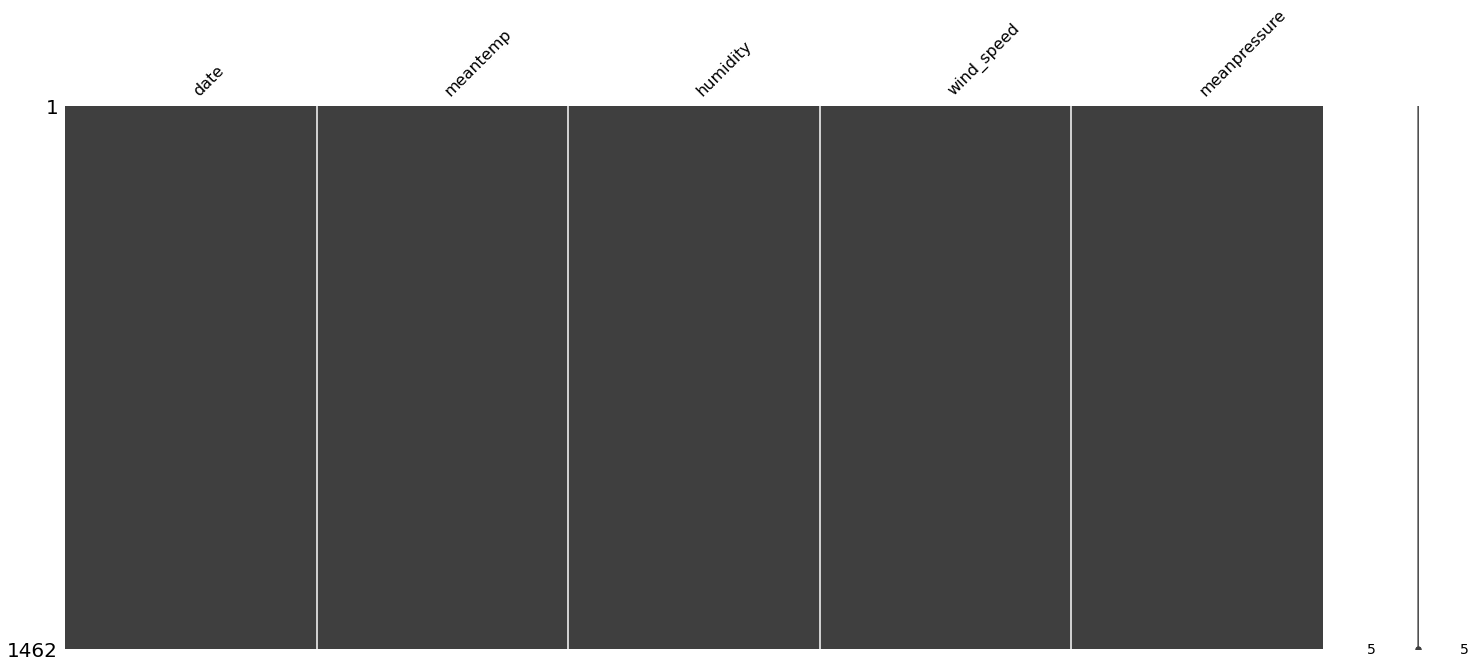

In [4]:
import missingno as m
m.matrix(train)

<AxesSubplot:>

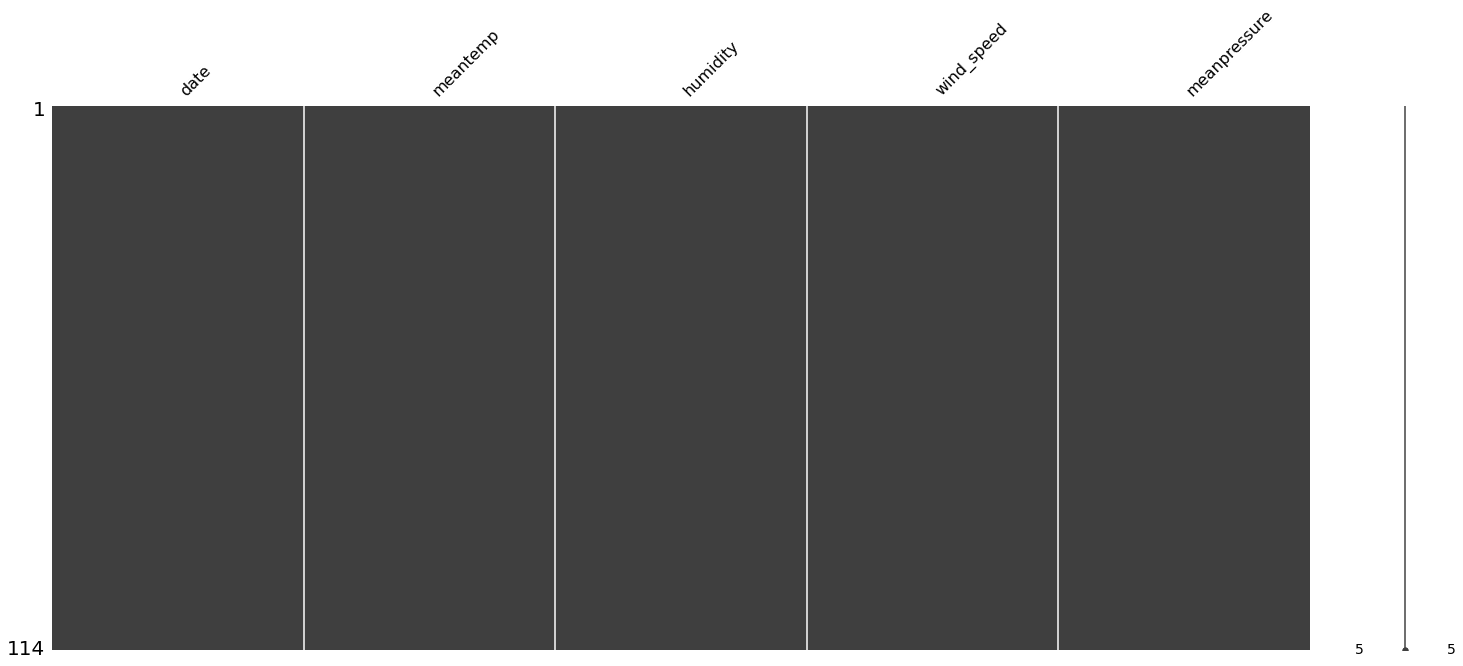

In [5]:
m.matrix(test)

### Data is already cleaned

In [6]:
train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [7]:
test.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


In [10]:
print(train.shape)
print(test.shape)

(1462, 5)
(114, 5)


# Explanatory Data Analysis (EDA)

In [112]:

import plotly.express as px
fig = px.box(y=train['meantemp'], points='all', title='Temperature')
fig.show()

In [114]:

fig = px.violin(y=train['humidity'], points='all', box= True, title='Humidity')
fig.show()

In [115]:
fig = px.violin(y=train['wind_speed'], points='all',box=True, title='Wind Speed')
fig.show()

### Temperature 

In [32]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter( x=train['date'], y=train['meantemp'], name='Real Price',
                         line=dict(color='royalblue', width=2)))


### Humidity

In [31]:
import plotly.graph_objects as go
fig2 = go.Figure()

fig2.add_trace(go.Scatter( x=train['date'], y=train['humidity'], name = 'Predicted Price',
                         line=dict(color='firebrick', width=2)))


### Wind Speed

In [33]:
import plotly.graph_objects as go
fig1 = go.Figure()

fig1.add_trace(go.Scatter( x=train['date'], y=train['wind_speed'], name = 'Predicted Price',
                         line=dict(color='green', width=2)))


## Temp, Humidity and wind speed plotting 

In [34]:
fig = px.scatter_3d(x=train['meantemp'], y=train['humidity'], z=train['wind_speed'],
              color=train['date'])
fig.show()

# Predicting Temperature of Delhi

In [35]:
temp_train = train.iloc[:,1:2]
temp_test = test.iloc[:,1:2]

# Feature Scaling 

In [36]:
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
temp_train= ss.fit_transform(temp_train)
temp_test= ss.fit_transform(temp_test)

In [37]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [38]:
look_back = 1
trainX, trainY = create_dataset(temp_train, look_back)
testX, testY = create_dataset(temp_test, look_back)

In [39]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

# Building the LSTM model

In [40]:
# create and fit the LSTM network
model_temp = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 100, return_sequences = True, input_shape = (trainX.shape[1], 1)))
model_temp.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 100, return_sequences = True))
model_temp.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 100, return_sequences = True))
model_temp.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 50))
model_temp.add(Dropout(0.2))
# Adding the output layer
model_temp.add(Dense(units = 1))

# Compiling with ADAM Optimizer and Mean Squared Error

In [41]:
# Compiling the RNN
model_temp.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the Dataset into the Model 

In [42]:
# Fitting the RNN to the Training set
model_temp.fit(trainX, trainY, epochs = 100, batch_size = 32)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/46 [==============================] - 0s 6ms/step - loss: 0.2089 - accuracy: 6.8493e-04
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0263 - accuracy: 0.0014
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.0014
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.00

46/46 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.0014
Epoch 70/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 0.0014
Epoch 71/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0039 - accuracy: 0.0014
Epoch 72/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 0.0014
Epoch 73/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.0014
Epoch 74/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 0.0014
Epoch 75/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 0.0014
Epoch 76/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.0014
Epoch 77/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.0014
Epoch 78/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.0014
Epoch 79/100


# Prediction for Test Set

In [43]:
prediction = model_temp.predict(testX)
prediction = ss.inverse_transform(prediction)
temp_test = ss.inverse_transform(temp_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [44]:
prediction

array([[16.402    ],
       [18.59336  ],
       [17.387064 ],
       [18.772514 ],
       [18.494408 ],
       [19.334488 ],
       [15.46504  ],
       [16.219866 ],
       [15.361991 ],
       [13.628409 ],
       [12.917432 ],
       [13.418097 ],
       [14.392883 ],
       [14.36818  ],
       [16.824512 ],
       [15.421047 ],
       [13.374589 ],
       [14.257923 ],
       [15.397755 ],
       [15.889831 ],
       [15.989576 ],
       [18.539875 ],
       [18.2546   ],
       [18.457943 ],
       [20.920963 ],
       [16.615772 ],
       [16.878029 ],
       [15.5827875],
       [16.205984 ],
       [16.832432 ],
       [16.572433 ],
       [15.879624 ],
       [17.37002  ],
       [16.18203  ],
       [18.772514 ],
       [18.711075 ],
       [17.20039  ],
       [15.782979 ],
       [16.232372 ],
       [15.976852 ],
       [15.433604 ],
       [16.173056 ],
       [16.673723 ],
       [16.74157  ],
       [17.188784 ],
       [17.77938  ],
       [20.203766 ],
       [21.21

In [45]:
temp_test.shape

(114, 1)

In [54]:
prediction.shape

(112, 1)

In [46]:
prediction1 = prediction

In [47]:
prediction.mean()

21.552158

In [48]:
prediction1 = np.append(prediction1, [21.90234,21.90234])

In [49]:
prediction1

prediction1 = prediction1.reshape(len(prediction1),1)
prediction1.shape

(114, 1)

# Predicted vs Real Value

In [51]:
data = np.concatenate((prediction1.reshape(len(prediction1),1), temp_test.reshape(len(temp_test),1)),1)
print(data)

[[16.40200043 15.91304348]
 [18.5933609  18.5       ]
 [17.38706398 17.11111111]
 [18.77251434 18.7       ]
 [18.49440765 18.38888889]
 [19.33448792 19.31818182]
 [15.46504021 14.70833333]
 [16.2198658  15.68421053]
 [15.36199093 14.57142857]
 [13.62840939 12.11111111]
 [12.91743183 11.        ]
 [13.41809654 11.78947368]
 [14.3928833  13.23529412]
 [14.36818027 13.2       ]
 [16.82451248 16.43478261]
 [15.42104721 14.65      ]
 [13.37458897 11.72222222]
 [14.25792313 13.04166667]
 [15.39775467 14.61904762]
 [15.88983059 15.26315789]
 [15.98957634 15.39130435]
 [18.53987503 18.44      ]
 [18.25460052 18.11764706]
 [18.45794296 18.34782609]
 [20.92096329 21.        ]
 [16.61577225 16.17857143]
 [16.87802887 16.5       ]
 [15.58278751 14.86363636]
 [16.20598412 15.66666667]
 [16.83243179 16.44444444]
 [16.57243347 16.125     ]
 [15.87962437 15.25      ]
 [17.37001991 17.09090909]
 [16.18202972 15.63636364]
 [18.77251434 18.7       ]
 [18.71107483 18.63157895]
 [17.20038986 16.88888889]
 

## Storing into CSV file 

In [52]:
dataset = pd.DataFrame({'Predicted': data[:, 0], 'Real': data[:, 1]})
dataset.to_csv('accuracy.csv')

## Storing the Accuracy

In [53]:
from sklearn.metrics import r2_score
meantemp = r2_score(temp_test, prediction1)

# Predicting Humidity of Delhi

In [55]:
# Humidity

humid_train = train.iloc[:,2:3]
humid_test = test.iloc[:,2:3]

In [56]:
#Scaling the values between 0 to 1

ss= MinMaxScaler(feature_range=(0,1))
humid_train= ss.fit_transform(humid_train)
humid_test= ss.fit_transform(humid_test)

In [57]:
look_back = 1
trainX, trainY = create_dataset(humid_train, look_back)
testX, testY = create_dataset(humid_test, look_back)

In [58]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

# Building the LSTM model

In [59]:
# create and fit the LSTM network
model_humid = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_humid.add(LSTM(units = 100, return_sequences = True, input_shape = (trainX.shape[1], 1)))
model_humid.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_humid.add(LSTM(units = 100, return_sequences = True))
model_humid.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_humid.add(LSTM(units = 100, return_sequences = True))
model_humid.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model_humid.add(LSTM(units = 50))
model_humid.add(Dropout(0.2))
# Adding the output layer
model_humid.add(Dense(units = 1))

# Compiling with ADAM Optimizer and Mean Squared Error

In [60]:
# Compiling the RNN
model_humid.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the Dataset into the Model

In [61]:
# Fitting the RNN to the Training set
model_humid.fit(trainX, trainY, epochs = 100, batch_size = 32)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/46 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 6.8493e-04
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 6.8493e-04
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 6.8493e-04
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - lo

46/46 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 6.8493e-04
Epoch 66/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 6.8493e-04
Epoch 67/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0093 - accuracy: 6.8493e-04
Epoch 68/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 6.8493e-04: 0s - loss: 0.0089 - accuracy: 0.0000
Epoch 69/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0094 - accuracy: 6.8493e-04
Epoch 70/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 6.8493e-04
Epoch 71/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 6.8493e-04
Epoch 72/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 6.8493e-04
Epoch 73/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 6.8493e-04
Epoch 74/100
46/46 [===================

# Prediction for Test Set

In [62]:
prediction = model_temp.predict(testX)
prediction = ss.inverse_transform(prediction)
humid_test = ss.inverse_transform(humid_test)

In [43]:
humid_test.shape

(114, 1)

In [63]:
prediction.shape

(112, 1)

In [64]:
prediction1 = prediction

In [65]:
prediction.mean()

56.869442

In [66]:
prediction1 = np.append(prediction1, [56.869442,56.869442])

In [68]:
prediction1

prediction1 = prediction1.reshape(len(prediction1),1)
prediction1.shape

(114, 1)

# Predicted vs Real Value

In [70]:
data = np.concatenate((prediction1.reshape(len(prediction1),1), humid_test.reshape(len(humid_test),1)),1)
print(data)

[[82.9958725  85.86956522]
 [76.33177185 77.22222222]
 [80.16364288 81.88888889]
 [69.68475342 70.05      ]
 [74.30209351 74.94444444]
 [78.11271667 79.31818182]
 [87.7649765  95.83333333]
 [81.38298035 83.52631579]
 [79.32180786 80.80952381]
 [71.50657654 71.94444444]
 [71.6649704  72.11111111]
 [73.96835327 74.57894737]
 [66.74398804 67.05882353]
 [73.69386292 74.28      ]
 [72.09486389 72.56521739]
 [77.38599396 78.45      ]
 [82.03422546 84.44444444]
 [77.28712463 78.33333333]
 [74.48238373 75.14285714]
 [66.16182709 66.47368421]
 [70.47747803 70.86956522]
 [75.46763611 76.24      ]
 [75.25386047 76.        ]
 [67.80497742 68.13043478]
 [69.59731293 69.96      ]
 [86.20749664 91.64285714]
 [76.17425537 77.04166667]
 [80.83075714 82.77272727]
 [80.07833862 81.77777778]
 [76.62093353 77.55555556]
 [75.25386047 76.        ]
 [77.53377533 78.625     ]
 [66.23332977 66.54545455]
 [77.15830231 78.18181818]
 [76.65931702 77.6       ]
 [76.68657684 77.63157895]
 [69.31180573 69.66666667]
 

## Storing into CSV file

In [71]:
dataset = pd.DataFrame({'Predicted': data[:, 0], 'Real': data[:, 1]})
dataset.to_csv('accuracy1.csv')

## Storing the Accuracy

In [74]:
from sklearn.metrics import r2_score
humidity = r2_score(humid_test, prediction1)

# Predicting Wind Speed of Delhi

In [76]:
wind_train = train.iloc[:,3:4]
wind_test = test.iloc[:,3:4]

In [77]:
wind_train= ss.fit_transform(wind_train)
wind_test= ss.fit_transform(wind_test)

In [78]:
look_back = 1
trainX, trainY = create_dataset(wind_train, look_back)
testX, testY = create_dataset(wind_test, look_back)

In [79]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

# Building the LSTM model

In [80]:
# create and fit the LSTM network
model_wind = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_wind.add(LSTM(units = 100, return_sequences = True, input_shape = (trainX.shape[1], 1)))
model_wind.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_wind.add(LSTM(units = 100, return_sequences = True))
model_wind.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_wind.add(LSTM(units = 100, return_sequences = True))
model_wind.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model_wind.add(LSTM(units = 50))
model_wind.add(Dropout(0.2))
# Adding the output layer
model_wind.add(Dense(units = 1))

# Compiling with ADAM Optimizer and Mean Squared Error

In [81]:
# Compiling the RNN
model_wind.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the Dataset into the Model

In [82]:
# Fitting the RNN to the Training set
model_wind.fit(trainX, trainY, epochs = 100, batch_size = 32)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/46 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.0164
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 0.0164
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0098 - accuracy: 0.0164
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.0098 - acc

46/46 [==============================] - 0s 6ms/step - loss: 0.0091 - accuracy: 0.0164
Epoch 69/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0092 - accuracy: 0.0164
Epoch 70/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0092 - accuracy: 0.0164
Epoch 71/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 0.0164
Epoch 72/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0093 - accuracy: 0.0164
Epoch 73/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0093 - accuracy: 0.0164
Epoch 74/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0091 - accuracy: 0.0164
Epoch 75/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 0.0164
Epoch 76/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0092 - accuracy: 0.0164
Epoch 77/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 0.0164
Epoch 78/100


# Prediction for Test Set

In [83]:
prediction = model_temp.predict(testX)
prediction = ss.inverse_transform(prediction)
wind_test = ss.inverse_transform(wind_test)

In [84]:
wind_test.shape

(114, 1)

In [85]:
prediction.shape

(112, 1)

In [86]:
prediction1 = prediction

In [87]:
prediction.mean()

8.237413

In [88]:
prediction1 = np.append(prediction1, [8.237413,8.237413])

In [89]:
prediction1

prediction1 = prediction1.reshape(len(prediction1),1)
prediction1.shape

(114, 1)

# Predicted vs Real Value

In [91]:
data = np.concatenate((prediction1.reshape(len(prediction1),1), wind_test.reshape(len(wind_test),1)),1)
print(data)

[[ 3.73403096  2.74347826]
 [ 3.83780599  2.89444444]
 [ 4.64376402  4.01666667]
 [ 5.0444665   4.545     ]
 [ 4.12201691  3.3       ]
 [ 8.63478279  8.68181818]
 [ 9.96107292 10.04166667]
 [ 3.20640326  1.95      ]
 [ 6.68208885  6.54285714]
 [ 9.29081059  9.36111111]
 [ 9.69435501  9.77222222]
 [ 6.75460911  6.62631579]
 [ 6.58909559  6.43529412]
 [ 5.62137508  5.276     ]
 [ 4.35947132  3.63043478]
 [10.29807758 10.38      ]
 [ 8.02839565  8.03888889]
 [ 6.24282646  6.02916667]
 [10.25622559 10.33809524]
 [11.14804554 11.22631579]
 [13.60119438 13.69565217]
 [ 6.1075635   5.868     ]
 [ 6.86524439  6.75294118]
 [ 4.1870985   3.39130435]
 [ 8.70570087  8.756     ]
 [ 8.43130684  8.46785714]
 [14.22436905 14.35833333]
 [ 9.61419392  9.69090909]
 [10.21266079 10.29444444]
 [ 4.87383986  4.32222222]
 [ 5.1063323   4.625     ]
 [ 5.48009634  5.1       ]
 [ 3.93001795  3.02727273]
 [ 3.14492488  1.85454545]
 [ 9.74152946  9.82      ]
 [ 8.08536911  8.1       ]
 [ 8.98318672  9.04444444]
 

## Storing into CSV file

In [92]:
dataset = pd.DataFrame({'Predicted': data[:, 0], 'Real': data[:, 1]})
dataset.to_csv('accuracy2.csv')

## Storing the Accuracy 

In [93]:
from sklearn.metrics import r2_score
wind_speed = r2_score(wind_test, prediction1)

# Reading All the CSV Files

In [102]:
dataset1 = pd.read_csv('accuracy.csv')
dataset2= pd.read_csv('accuracy1.csv')
dataset3= pd.read_csv('accuracy2.csv')

# Predicted vs Actual Value for Temperature

In [116]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter( y=dataset1.Real, name='Real',
                         line=dict(color='black', width=3)))
fig.add_trace(go.Scatter( y=dataset1.Predicted, name = 'Predicted',
                         line=dict(color='firebrick', width=2)))

# Predicted vs Actual Value for Humidity

In [117]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter( y=dataset2.Real, name='Real',
                         line=dict(color='royalblue', width=3)))
fig.add_trace(go.Scatter( y=dataset2.Predicted, name = 'Predicted',
                         line=dict(color='firebrick', width=2)))

# Predicted vs Actual Value for Wind Speed

In [118]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter( y=dataset3.Real, name='Real',
                         line=dict(color='green', width=3)))
fig.add_trace(go.Scatter( y=dataset3.Predicted, name = 'Predicted',
                         line=dict(color='firebrick', width=2)))

# Accuracy

In [111]:
print("Accuracy of Temperature : ",meantemp)
print("Accuracy of Humidity: ",humidity)
print("Accuracy of Wind Speed: ",wind_speed)

Accuracy of Temperature :  0.9398398517465097
Accuracy of Humidity:  0.9486044063746508
Accuracy of Wind Speed:  0.9714925959639059


# Temperature - 93.9%
# Humidity - 94.8%
# Wind Speed - 97%

# This model can Successfully Predict the Climate of Delhi in terms of Temperature, Humidity and Wind Speed with very good Accuracy 